In [2]:
import numpy as np
import pandas as pd 

In [3]:
%cd /kaggle/input/march-machine-learning-mania-2024

/kaggle/input/march-machine-learning-mania-2024


In [4]:
t_type = 'M'

# Data Preparation

## Web Scraping

In [13]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import sys
import ssl

In [14]:
days = {2022:16,2023:15,2021:18,2019:21,2018:14,
        2017:15,2016:16,2015:18,2014:17,2013:18,2012:12,
        2011:14,2010:15,2009:16,2008:17,2007:11,2006:13,
        2005:14
       }
teams_spellings = pd.read_csv('MTeamSpellings.csv', encoding='cp1252')
replace = {'north':'n','west':'w','eastern':'e',
           'northern':'n','western':'w','east':'e',
           'georgia': 'ga','college':'col','mississippi':'miss',
           'south':'s','southern':'s','washington':'wash',
           'louisiana':'la','st.':'st','michigan':'mich',
           'alabama':'alab','bluff':'bl'}
rep_fun = lambda s: ' '.join([x if x not in replace else replace[x] for x in s.split()])
names = teams_spellings.TeamNameSpelling.apply(rep_fun)
mask = (names!=teams_spellings.TeamNameSpelling)
df_ = pd.DataFrame({'TeamNameSpelling':list(names[mask])\
                    +['miami','st johns','va tech','il-chicago','geo mason',
                      'st marys','loyola-chi','col charlestn'],
                    'TeamID':list(teams_spellings.TeamID[mask])\
                    +[1274,1385,1439,1227,1206,1388,1260,1158]})
teams_spellings = pd.concat((teams_spellings,df_),axis=0)

def get_sos_teamrankings(y):
    d = days[y]
    url = f"https://www.teamrankings.com/ncaa-basketball/ranking/schedule-strength-by-other?date={y}-03-{d}"
    page = urlopen(url).read()
    soup = BeautifulSoup(page)
    table = soup.find("tbody")
    r = list()
    for row in table.findAll('td'):
        r.append(row.getText())
    df = pd.DataFrame(np.array(r).reshape(-1,6),
                  columns=['Rank','Team_WL','TR_SOS_Rating','High','Low','Last'])
    df['Team_Name'] = df.Team_WL.apply(lambda x: ' ('.join(x.split(' (')[:-1]).lower())
    return df.merge(teams_spellings,left_on='Team_Name',right_on='TeamNameSpelling',how='left')[['TeamID','TR_SOS_Rating']]

206


## Compute Metrics From Regular Season

In [15]:
#strenght of schedule
game_weights = {'A':0.66,'H':0.33,'N':0.5,}
def _sos(team,season_games,ranking_df,metric,location=True):
    opponent = np.concatenate((season_games.loc[season_games['WTeamID']==team,'LTeamID'],
                               season_games.loc[season_games['LTeamID']==team,'WTeamID']))
    loc_weight = np.concatenate((season_games.loc[season_games['WTeamID']==team,
                                                  'WLoc'].map(game_weights),
                                 1-season_games.loc[season_games['LTeamID']==team,
                                                  'WLoc'].map(game_weights)))
    r = pd.DataFrame({'TeamID':opponent}).merge(ranking_df,how='left')[metric]
    return [(r.values*loc_weight).mean()*2]

def get_sos(season,*args,**kwargs):
    season_games = games[games['Season']==season]
    team_ids = np.union1d(season_games['WTeamID'],season_games['LTeamID'])
    stats = list()
    for team in team_ids:
        stats.append(_sos(team,season_games,*args,**kwargs))
    sos = pd.DataFrame(np.stack(stats),
                         columns=['sos'])
    sos['TeamID'] = team_ids
    return sos

In [16]:
def get_stats(team,season_games):
    wins = season_games.loc[season_games['WTeamID'] == team,['WScore','LScore']]
    losses = season_games.loc[season_games['LTeamID'] == team,['LScore','WScore']]
    ppg = np.concatenate((wins.values,losses.values)).mean(axis=0)
    pts_var = np.concatenate((wins.values,losses.values)).var(axis=0)**0.5
    
    return np.concatenate((ppg,pts_var,[len(wins),len(losses)]))

def get_pts_stats(season):
    season_games = games[games['Season']==season]
    team_ids = np.union1d(season_games['WTeamID'],season_games['LTeamID'])
    stats = list()
    for team in team_ids:
        stats.append(get_stats(team,season_games))
    pts_stats = pd.DataFrame(np.stack(stats),
                         columns=['ppg','opp_ppg','ppg_sd','opp_ppg_sd','W','L'])
    pts_stats['W%'] = pts_stats['W']/(pts_stats['W']+pts_stats['L'])
    pts_stats['TeamID'] = team_ids
    return pts_stats

def off_def_scores(team,season_games,pts_stats):
    #opp id, your pts, opp pts
    wins = season_games.loc[season_games['WTeamID'] == team,
                            ['LTeamID','WScore','LScore']].values
    losses = season_games.loc[season_games['LTeamID'] == team,
                              ['WTeamID','LScore','WScore']].values
    rslts = pd.DataFrame(np.concatenate((wins,losses)),
                         columns=['TeamID','pts','opp_pts'])
    #opponent's overall stats
    rslts = rslts.merge(pts_stats,on='TeamID')
    #opp: difference between average points and points against you
    op_pt_dif = rslts['opp_pts']-rslts['ppg']
    #difference between average points and points against you
    pt_dif = rslts['pts']-rslts['opp_ppg']
    return np.array([op_pt_dif.mean(),pt_dif.mean(),
                      op_pt_dif.var()**0.5,pt_dif.var()**0.5])

def get_off_def_stats(season,pts_stats):
    season_games = games[games['Season']==season]
    team_ids = np.union1d(season_games['WTeamID'],season_games['LTeamID'])
    stats = list()
    for team in team_ids:
        stats.append(off_def_scores(team,season_games,pts_stats))
    off_def = pd.DataFrame(np.stack(stats),
                         columns=['op_pt_dif','pt_dif','op_pt_dif_sd','pt_dif_sd'])
    off_def['TeamID'] = team_ids
    return off_def

In [17]:
import networkx as nx
games = pd.read_csv(f'{t_type}RegularSeasonDetailedResults.csv')
seeds = pd.read_csv(f'{t_type}MNCAATourneySeeds.csv')
tourney = pd.read_csv(f'{t_type}NCAATourneyCompactResults.csv')

def get_page_rank(season):
    season_games = games[games['Season']==season].copy()
    
    game_weights = {'A':0.66,'H':0.33,'N':0.5,}

    team_ids = np.union1d(season_games['WTeamID'],season_games['LTeamID'])
    n = len(team_ids)
    id_to_ind = dict(zip(team_ids,np.arange(n)))

    #adjacency matrix
    A = np.zeros((n,n))
    for i in season_games.index:
        w_id = season_games.loc[i,'WTeamID']
        l_id = season_games.loc[i,'LTeamID']
        pts_factor = (season_games.loc[i,'WScore']-season_games.loc[i,'LScore'])/season_games.loc[i,'WScore']
        time_factor = (0.25 + 0.75*season_games.loc[i,'DayNum']/132)
        location_factor = game_weights[season_games.loc[i,'WLoc']]
        A[id_to_ind[l_id],id_to_ind[w_id]] += pts_factor*time_factor
    G=nx.DiGraph(A)
    pr=nx.pagerank(G,1.)
    pr = {team_ids[k]:v for k,v in pr.items()}
    page_ranks = pd.DataFrame([list(i) for i in pr.items()],columns=['TeamID','PageRank'])
    return pr,page_ranks

def get_seeds(season):
    if type(season) == list:
        s = seeds[seeds['Season'].isin(season)].copy()
    else:
        s = seeds[seeds['Season']==season].copy()
    s['Seed'] = s['Seed'].apply(lambda x: int(x[1:3]))
    return s

def get_rounds(season):
    t = tourney[tourney['Season']==season].copy()
    winner_counts = t['WTeamID'].value_counts()
    losers = t['LTeamID'].value_counts()
    losers[~losers.index.isin(winner_counts.index)] = 0
    losers = losers[~losers.index.isin(winner_counts.index)]
    rounds_survived = pd.concat((winner_counts,losers,))
    rounds_survived = pd.DataFrame(rounds_survived)
    rounds_survived['TeamID'] = rounds_survived.index
    return rounds_survived

In [20]:
teams = pd.read_csv(f'{t_type}Teams.csv')
ranks = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/MMasseyOrdinals.csv')
def get_ranks(y):
    test_ranks = ranks[(ranks['Season']==y)&(ranks['RankingDayNum']==133)]
    return pd.pivot_table(test_ranks, values='OrdinalRank', index=['TeamID'],
               columns=['SystemName'])

# Build Dataset

In [21]:
#shuffle NCAA tournament games
np.random.seed(12)
tourney['mask'] = np.random.choice([True,False],size=len(tourney))
tourney['team1'] = tourney.apply(lambda x: x['WTeamID'] if x['mask'] else x['LTeamID'], axis=1)
tourney['team2'] = tourney.apply(lambda x: x['LTeamID'] if x['mask'] else x['WTeamID'], axis=1)
tourney

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,mask,team1,team2
0,1985,136,1116,63,1234,54,N,0,False,1234,1116
1,1985,136,1120,59,1345,58,N,0,False,1345,1120
2,1985,136,1207,68,1250,43,N,0,True,1207,1250
3,1985,136,1229,58,1425,55,N,0,False,1425,1229
4,1985,136,1242,49,1325,38,N,0,False,1325,1242
...,...,...,...,...,...,...,...,...,...,...,...
2446,2023,146,1274,88,1400,81,N,0,True,1274,1400
2447,2023,146,1361,57,1166,56,N,0,True,1361,1166
2448,2023,152,1163,72,1274,59,N,0,False,1274,1163
2449,2023,152,1361,72,1194,71,N,0,False,1194,1361


In [22]:
def get_season_data(y):
    pr,pr_df = get_page_rank(y)
    s = get_seeds(y)
    if t_type=='M':
        r = get_ranks(y)
        tr_sos = get_sos_teamrankings(y)
    pts_stats = get_pts_stats(y)
    off_def = get_off_def_stats(y,pts_stats)
    sos = get_sos(y,pts_stats,'W%')
    df = pr_df.merge(s,on='TeamID')\
    .merge(pts_stats,on='TeamID')\
    .merge(off_def,on='TeamID',how='left')\
    .merge(sos,on='TeamID',how='left')
    if t_type =='M':
        df = df.merge(r,on='TeamID')
        .merge(tr_sos,on='TeamID',how='left')
    return df

In [127]:
from tqdm import tqdm
pre_compute = True
train_years = np.arange(2005,2020)
if pre_compute:
    train = pd.read_csv('/kaggle/input/ncaa-2005-2019-predictors/x_2005-2019_data.csv')
else:
    train = list()
    for y in tqdm(train_years):
        df = get_season_data(y)
        df['Season'] = y
        train.append(df)
    train = pd.concat(train).reset_index(drop=True)
    train.to_csv('/kaggle/working/x_2005-2019_data.csv')

In [24]:
train_data = tourney[tourney.Season.isin(train_years)]\
.merge(train, left_on=['team1','Season'],right_on=['TeamID','Season'],how='left')\
.merge(train, left_on=['team2','Season'],right_on=['TeamID','Season'],how='left',suffixes=('_1','_2'))

# Build Models

In [94]:
#original predictors
x_names = ['PageRank','Seed','MOR','MAS','ppg','opp_ppg',
           'opp_ppg_sd','op_pt_dif','pt_dif','op_pt_dif_sd','pt_dif_sd',
           'W','L','W%','sos','TR_SOS_Rating']

In [25]:
#trimmed predictors
x_names = ['PageRank','Seed','MOR','MAS','ppg','opp_ppg',
           'op_pt_dif','pt_dif',
           'W','L','W%','TR_SOS_Rating']
td = train_data.fillna(0)
x_train = td[[x+'_1' for x in x_names]].values-td[[x+'_2' for x in x_names]].values
other = []
x_names+=other
x_train = np.concatenate((x_train,train_data[other].fillna(0)),axis=1)

## Logistic Regression

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=300,C=10,fit_intercept=False)
parameters = {'C':[0.1,0.25,0.5, 1, 10, 50, 75, 100,250, 500,1000]}
clf = GridSearchCV(model, parameters, cv=4, n_jobs=4)
clf.fit(x_train,train_data['mask'].astype(int))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=4,
             estimator=LogisticRegression(C=10, fit_intercept=False,
                                          max_iter=300),
             n_jobs=4,
             param_grid={'C': [0.1, 0.25, 0.5, 1, 10, 50, 75, 100, 250, 500,
                               1000]})

In [27]:
clf.cv_results_['params'][np.argmax(clf.cv_results_['mean_test_score'])],np.max(clf.cv_results_['mean_test_score'])

({'C': 0.1}, 0.7122292747292748)

In [28]:
model = LogisticRegression(max_iter=300,**clf.cv_results_['params'][np.argmax(clf.cv_results_['mean_test_score'])],fit_intercept=False)
model.fit(x_train,train_data['mask'].astype(int))

LogisticRegression(C=0.1, fit_intercept=False, max_iter=300)

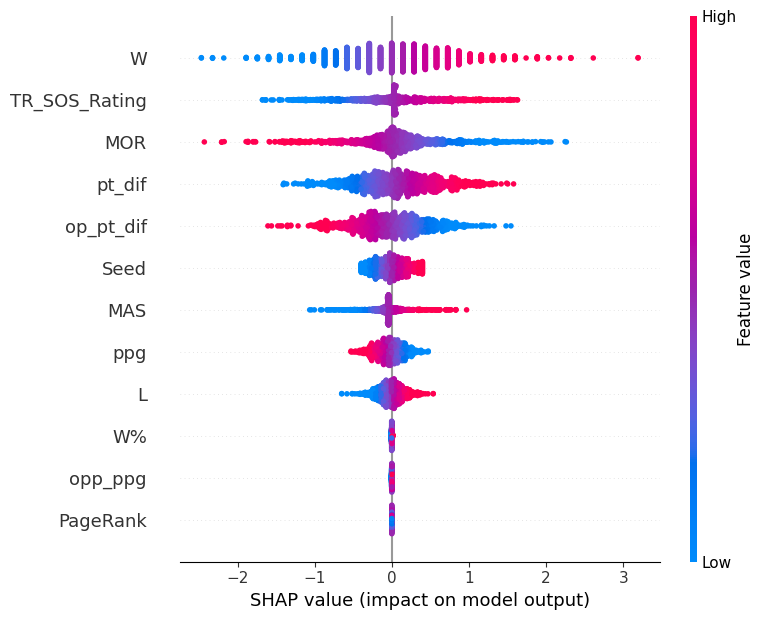

In [29]:
import shap
explainer = shap.LinearExplainer(model,x_train)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values,x_train,max_display=len(x_names),feature_names=x_names)

## XGBoost Model

In [30]:
import xgboost as xgb
parameters = {
    'max_depth': [1,2],
    'n_estimators': [25,75,100],
    'eta': [0.1,0.3],
    'reg_lambda':[1,10],
    'reg_alpha':[1,10,50]
}
booster = xgb.XGBRegressor(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
clf = GridSearchCV(booster, parameters, cv=4)

clf.fit(x_train,train_data['mask'].astype(int))

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, nthread=4,
                                    num_parallel_tree=None, ...),
             param_grid={'eta': [0.1, 0.3], 'max_depth': [1, 2],
                         'n_estimators': [25, 75, 100],
                         'reg_alpha': [1, 10, 50], 'reg_lambda': [1, 10]})

In [31]:
clf.cv_results_['params'][np.argmax(clf.cv_results_['mean_test_score'])],np.max(clf.cv_results_['mean_test_score'])

({'eta': 0.1,
  'max_depth': 1,
  'n_estimators': 100,
  'reg_alpha': 1,
  'reg_lambda': 1},
 0.23486687228684724)

In [32]:
booster.set_params(**clf.cv_results_['params'][np.argmax(clf.cv_results_['mean_test_score'])])
xgbm = booster.fit(x_train,train_data['mask'].astype(int))

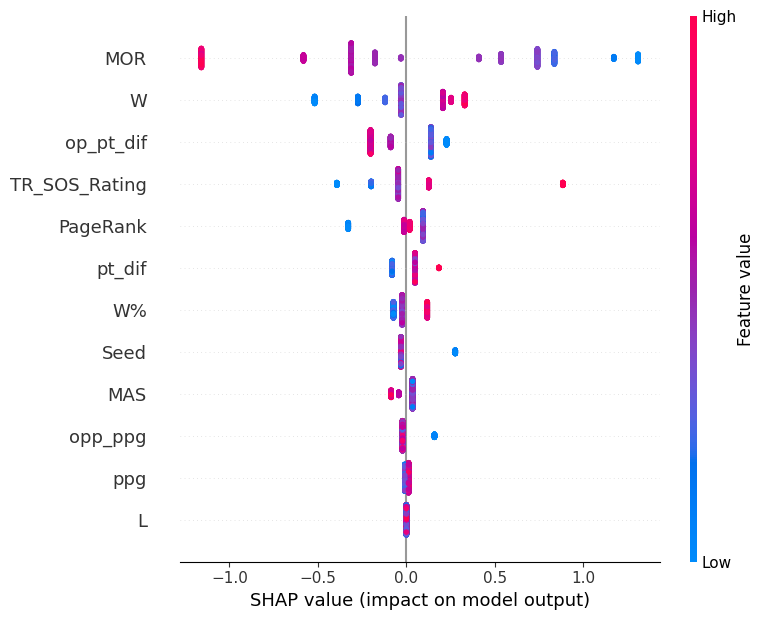

In [33]:
import shap
explainer = shap.TreeExplainer(xgbm,x_train)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, max_display=len(x_names),feature_names=x_names)

In [34]:
import pickle
file_name = "/kaggle/working/xgb_reg.pkl"

# save
pickle.dump(xgbm, open(file_name, "wb"))


## Training Metrics

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_data['mask'].astype(int), xgbm.predict(x_train)),\
roc_auc_score(train_data['mask'].astype(int), model.predict(x_train))

(0.8275944108546127, 0.7262954246280267)

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('XGB accuracy',accuracy_score(train_data['mask'].astype(int),xgbm.predict(x_train)>0.5))
print('GLM accurcy',accuracy_score(train_data['mask'].astype(int),model.predict(x_train)))
print('Seed accuracy',accuracy_score(train_data['mask'].astype(int),train_data['Seed_1']<train_data['Seed_2']))

XGB accuracy 0.7350210970464135
GLM accurcy 0.7265822784810126
Seed accuracy 0.7029535864978903


## Test On Recent Tournaments

In [37]:
y = 2022
test = get_season_data(y).drop_duplicates()
test['Season'] = y
df = tourney[tourney.Season==y]\
.merge(test, left_on=['team1','Season'],right_on=['TeamID','Season'],how='left')\
.merge(test, left_on=['team2','Season'],right_on=['TeamID','Season'],how='left',
       suffixes=('_1','_2')).fillna(0)

dif_names = np.setdiff1d(x_names,other)
x_test = df[[x+'_1' for x in dif_names]].astype(float).values-df[[x+'_2' for x in dif_names]].astype(float).values
x_test = np.concatenate((x_test,df[other].fillna(0).values),axis=1)

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('XGB accuracy',accuracy_score(df['mask'].astype(int),xgbm.predict(x_test)>0.5))
print('GLM accurcy',accuracy_score(df['mask'].astype(int),model.predict(x_test)))
print('PageRank accurcy',accuracy_score(df['mask'].astype(int),df['PageRank_1']>df['PageRank_2']))
print('Seed accuracy',accuracy_score(df['mask'].astype(int),df['Seed_1']<df['Seed_2']))

XGB accuracy 0.6417910447761194
GLM accurcy 0.3880597014925373
PageRank accurcy 0.6716417910447762
Seed accuracy 0.6865671641791045


In [40]:
roc_auc_score(df['mask'].astype(int),xgbm.predict(x_test)),\
roc_auc_score(df['mask'].astype(int),model.predict_proba(x_test).T[1]),\
roc_auc_score(df['mask'].astype(int),df['PageRank_1']-df['PageRank_2']),\
roc_auc_score(df['mask'].astype(int),df['Seed_2']-df['Seed_1'])

(0.6442307692307693,
 0.37545787545787546,
 0.7344322344322344,
 0.7152014652014653)

### Build a Bracket

In [41]:
seeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySeeds.csv')
teams = pd.read_csv('MTeams.csv')
season_seeds = seeds[(seeds.Season==y)].copy()
season_tourney = tourney[tourney.Season==y].copy()
order  = ['01','16','08','09','04','13','05','12','06','11','03','14','07','10','02','15']
regions = ['W','X','Y','Z']
ordered_ids = np.hstack([[r+s for s in order] for r in regions])

In [42]:
mask = season_seeds.Seed.isin(ordered_ids)
frw = season_seeds[~mask].merge(season_tourney,left_on='TeamID',
                                               right_on='WTeamID',how='inner')\
.drop_duplicates('Seed')['Seed']
frw = {i:i[:-1] for i in frw}
season_seeds['Seed'] = season_seeds.Seed.replace(frw)
ordered_ids = season_seeds.set_index('Seed').loc[ordered_ids,'TeamID']

## Optimize Bracket for Expected Points

In [43]:
import numpy as np
N = 64

prob_cache = {}
def prob_win(t1_id,t2_id):
    #probability of team 1 beating team 2 using models
    if (t1_id,t2_id) in prob_cache:
        return prob_cache[(t1_id,t2_id)]
    X = test.loc[test.TeamID==t1_id,x_names].astype(float).fillna(0).values\
        -test.loc[test.TeamID==t2_id,x_names].astype(float).fillna(0).values
    #prob_cache[(t1_id,t2_id)] = model.predict_proba(X)[0,1]
    prob_cache[(t1_id,t2_id)] = xgbm.predict(X).item()
    return prob_cache[(t1_id,t2_id)]

In [44]:
import math
def ALL_TEAMS(t,r):
    offset = (math.ceil((t+1)/2**r)-1)*2**r
    return np.arange(2**(r-1)) + offset + (t<(2**(r-1)+offset))*(2**(r-1))

p_cache = {}

def p(t,r):
    """
    Get the probability of team t making it to round r
    """
    if r == 0:
        return 1
    elif (t,r) in p_cache:#cache results to avoid unnecessary recursion
        return p_cache[(t,r)]
    else:
        #find potential other teams
        O = ALL_TEAMS(t,r)
        #probability of team t making it to round r-1 * probability of team t beating the other team
        p_cache[(t,r)] = p(t,r-1)*sum([prob_win(ordered_ids.iloc[t],ordered_ids.iloc[o])*p(o,r-1) for o in O])
        return p_cache[(t,r)]

def expected_points(head):
    #find the expected number of points for a particular bracket
    pts = 0
    if 'r' in dir(head):
        pts += expected_points(head.r)
    if 'l' in dir(head):
        pts += expected_points(head.l)
    return head.R*p(head.payload,int(math.log(head.R,2))) + pts

In [45]:
class Node:
    def __init__(self,payload,R,TeamID):
        self.payload = payload
        self.TeamID = TeamID
        self.R = R

def build_tree_random(teams,p=None):
    if len(teams)==2:
        if p is None:
            #calculate the probability of winning
            p = prob_win(ordered_ids.iloc[teams[0]],ordered_ids.iloc[teams[1]])
        elif p=='greedy':
            #choose the team with the greatest probability of winning the game
            p = int(prob_win(ordered_ids.iloc[teams[0]],ordered_ids.iloc[teams[1]])>0.5)
        #choose winner based on probability
        w = np.random.choice(teams,p=[p,1-p])
        w = Node(w,2,ordered_ids.iloc[w])
        w.r = Node(teams[0],1,ordered_ids.iloc[teams[0]])
        w.l = Node(teams[1],1,ordered_ids.iloc[teams[1]])
        return w
    mid = len(teams)//2
    r = build_tree_random(teams[:mid],p)
    l = build_tree_random(teams[mid:],p)
    if p is None:
        p = prob_win(r.TeamID,r.TeamID)
    elif p == 'greedy':
        p = int(prob_win(r.TeamID,r.TeamID)>0.5)
    w = np.random.choice([r.payload,l.payload],p=[p,1-p])
    w = Node(w,2*r.R,ordered_ids.iloc[w])
    w.r = r
    w.l = l
    return w

teams_names = pd.read_csv(f'{t_type}Teams.csv')
def in_order(head):
    #print bracket out
    if 'r' in dir(head):
        in_order(head.r)
    print(''.join(['--']*(head.R-1)),teams_names.loc[teams_names.TeamID==head.TeamID,'TeamName'].values[0])
    if 'l' in dir(head):
        in_order(head.l)

#### Build a Greedy Bracket


In [46]:
teams = [i for i in range(N)]
winner = build_tree_random(teams,'greedy')
in_order(winner)
print(expected_points(winner)/2)

 Baylor
-- Baylor
 Norfolk St
------ North Carolina
 North Carolina
-- North Carolina
 Marquette
-------------- St Mary's CA
 UCLA
-- UCLA
 Akron
------ St Mary's CA
 St Mary's CA
-- St Mary's CA
 Indiana
------------------------------ Kentucky
 Texas
-- Virginia Tech
 Virginia Tech
------ Purdue
 Purdue
-- Purdue
 Yale
-------------- Kentucky
 Murray St
-- Murray St
 San Francisco
------ Kentucky
 Kentucky
-- Kentucky
 St Peter's
-------------------------------------------------------------- Duke
 Gonzaga
-- Gonzaga
 Georgia St
------ Boise St
 Boise St
-- Boise St
 Memphis
-------------- Connecticut
 Arkansas
-- Vermont
 Vermont
------ Connecticut
 Connecticut
-- Connecticut
 New Mexico St
------------------------------ Duke
 Alabama
-- Alabama
 Notre Dame
------ Texas Tech
 Texas Tech
-- Texas Tech
 Montana St
-------------- Duke
 Michigan St
-- Michigan St
 Davidson
------ Duke
 Duke
-- Duke
 CS Fullerton
-----------------------------------------------------------------------------

#### Select Random Brackets

(array([ 1.,  2.,  1.,  3.,  7.,  3.,  7.,  5.,  7., 11.,  9.,  6.,  5.,
         4.,  6.,  5.,  5.,  0.,  3.,  6.,  1.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.]),
 array([50.50510528, 51.70181858, 52.89853187, 54.09524516, 55.29195846,
        56.48867175, 57.68538505, 58.88209834, 60.07881164, 61.27552493,
        62.47223823, 63.66895152, 64.86566481, 66.06237811, 67.2590914 ,
        68.4558047 , 69.65251799, 70.84923129, 72.04594458, 73.24265787,
        74.43937117, 75.63608446, 76.83279776, 78.02951105, 79.22622435,
        80.42293764, 81.61965094, 82.81636423, 84.01307752, 85.20979082,
        86.40650411]),
 <BarContainer object of 30 artists>)

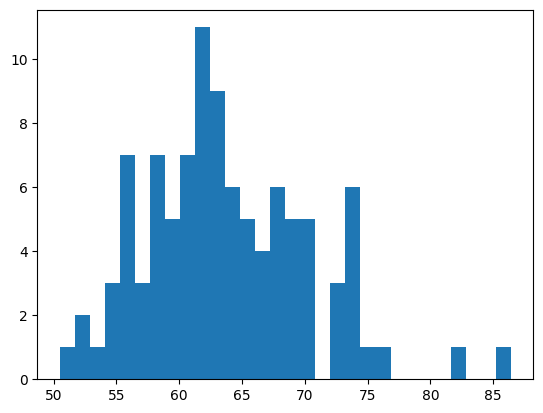

In [95]:

rand_scores = list()
best_score = 0
for i in range(100):
    winner = build_tree_random(teams,0.5)
    rand_scores.append(expected_points(winner)/2)
    if rand_scores[-1] > best_score:
        best = winner
        best_score = rand_scores[-1]
import matplotlib.pyplot as plt
plt.hist(rand_scores,bins=30)

In [96]:
print(best_score)
in_order(best)

86.4065041130086
 Baylor
-- Baylor
 Norfolk St
------ Baylor
 North Carolina
-- North Carolina
 Marquette
-------------- Baylor
 UCLA
-- UCLA
 Akron
------ Indiana
 St Mary's CA
-- Indiana
 Indiana
------------------------------ Kentucky
 Texas
-- Virginia Tech
 Virginia Tech
------ Purdue
 Purdue
-- Purdue
 Yale
-------------- Kentucky
 Murray St
-- Murray St
 San Francisco
------ Kentucky
 Kentucky
-- Kentucky
 St Peter's
-------------------------------------------------------------- Texas Tech
 Gonzaga
-- Gonzaga
 Georgia St
------ Gonzaga
 Boise St
-- Memphis
 Memphis
-------------- Vermont
 Arkansas
-- Vermont
 Vermont
------ Vermont
 Connecticut
-- Connecticut
 New Mexico St
------------------------------ Texas Tech
 Alabama
-- Notre Dame
 Notre Dame
------ Texas Tech
 Texas Tech
-- Texas Tech
 Montana St
-------------- Texas Tech
 Michigan St
-- Michigan St
 Davidson
------ Michigan St
 Duke
-- CS Fullerton
 CS Fullerton
----------------------------------------------------------

#### Generate Brackets Based on Probability

In [389]:
# random search
best_tree = None
best_score = 0

In [390]:
from tqdm import tqdm
for i in tqdm(range(10000)):
    winner = build_tree_random(teams)
    score = expected_points(winner)
    if score > best_score:
        best_score = score
        best_tree = winner

100%|██████████| 10000/10000 [01:15<00:00, 132.20it/s]


In [391]:
best_score/2,N*math.log(N,2)/2

(103.74761524995523, 192.0)

In [392]:
in_order(best_tree)

 Baylor
-- Baylor
 Norfolk St
------ Baylor
 North Carolina
-- North Carolina
 Marquette
-------------- Baylor
 UCLA
-- UCLA
 Akron
------ UCLA
 St Mary's CA
-- Indiana
 Indiana
------------------------------ Kentucky
 Texas
-- Texas
 Virginia Tech
------ Purdue
 Purdue
-- Purdue
 Yale
-------------- Kentucky
 Murray St
-- San Francisco
 San Francisco
------ Kentucky
 Kentucky
-- Kentucky
 St Peter's
-------------------------------------------------------------- Kentucky
 Gonzaga
-- Gonzaga
 Georgia St
------ Gonzaga
 Boise St
-- Boise St
 Memphis
-------------- Gonzaga
 Arkansas
-- Arkansas
 Vermont
------ Arkansas
 Connecticut
-- New Mexico St
 New Mexico St
------------------------------ Duke
 Alabama
-- Notre Dame
 Notre Dame
------ Notre Dame
 Texas Tech
-- Texas Tech
 Montana St
-------------- Duke
 Michigan St
-- Davidson
 Davidson
------ Duke
 Duke
-- Duke
 CS Fullerton
-------------------------------------------------------------------------------------------------------------

## Generate Submission

In [ ]:
def get_submission_format(tree):
    winners = list()
    def post_order(head):
        if 'r' in dir(head) and 'r' in dir(head.r):
            post_order(head.r)
        if 'l' in dir(head) and 'r' in dir(head.l):
            post_order(head.l)
        seed_ = seeds.loc[(seeds.TeamID==head.TeamID)&(seeds.Season==y),'Seed'].item()
        slot_ = f"R{int(math.log(head.R,2))}{seed_[0]}{order.index(seed_[1:3])//(head.R//2+1)+1:02d}"
        if slot_.startswith('R5'):
            slot_ = 'R5WX' if 'X' in slot_ or 'W' in slot_ else 'R5YZ'
        elif slot_.startswith('R6'):
            slot_='R6CH'
        winners.append((seed_,slot_))
    post_order(tree)
    sub_df = pd.DataFrame(winners,columns=['Seed','Round']).sort_values('Round').reset_index(drop=True)
    return sub_df

In [5]:
submission = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/sample_submission.csv')
submission[submission.Tournament=='M']

,RowId,Tournament,Bracket,Slot,Team
0,0,M,1,R1W1,W01
1,1,M,1,R1W8,W08
2,2,M,1,R1W5,W05
3,3,M,1,R1W4,W04
4,4,M,1,R1W6,W06
...,...,...,...,...,...
58,58,M,1,R4Y1,Y01
59,59,M,1,R4Z1,Z01
60,60,M,1,R5WX,W01
61,61,M,1,R5YZ,Y01


In [ ]:
get_submission_format(winner)

### Build 10,000 Brackets

In [ ]:
from tqdm import tqdm
submission = list()
for i in tqdm(range(10000)):
    winner = build_tree_random(teams)
    sub_df = get_submission_format(winner)
    sub_df['Bracket'] = i
    sub_df['Tournament'] = t_type
    submission.append(sub_df)
    score = expected_points(winner)
    if score > best_score:
        best_score = score
        best_tree = winner
submission = pd.concat(submission).reset_index(drop=True)
submission.to_csv(f'/kaggle/working/submission_{t_type}_{y}.csv')

# Other Code

In [ ]:
tourney_23 = tourney[tourney['Season']==2023].copy()
def win_percentage(metric,greater_better=True):
    winner_prediction = tourney_23.merge(df,left_on='WTeamID',right_on='TeamID',how='left')[metric]
    loser_prediction = tourney_23.merge(df,left_on='LTeamID',right_on='TeamID',how='left')[metric]
    p = (winner_prediction>loser_prediction).mean()
    tie = (winner_prediction==loser_prediction).mean()
    p += tie/2
    if greater_better:
        return p
    else:
        return 1-p